In [42]:
### Imports

import matplotlib.pyplot as plt
import numpy as np
import requests
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from urllib.parse import urlparse, parse_qs

ENDPOINT = 'http://games.espn.com/ffl/api/v2/leagueSettings'

In [2]:
### Retrieve data from leaderboard

web_data = requests.get('http://games.espn.com/ffl/resources/leaderboard?leaderboardGroupId=15')
parsed_data = BeautifulSoup(web_data.content, 'html.parser')

In [3]:
### Get list of LeagueIds

league_ids = []
rows = parsed_data.select('tr')

for i in range(3, len(rows)):
    endpoint = rows[i].find('a')['href']
    url = urlparse(endpoint)
    params = parse_qs(url.query)
    league_ids.append(params['leagueId'][0])

In [4]:
### Initialize data dict (key is draft position)

leagues_traversed = []
data = {}
for i in range(1,13):
    data[str(i)] = {
        "position_finishes": [],
        "points_for": []
    }

In [5]:
### Function definition for retrieving league data

def get_league_response(league_id):
    params = {
        'leagueId': league_id,
        'seasonId': 2017
    }
    
    r = requests.get(ENDPOINT, params=params, timeout=10)     
    
    if r.status_code == 200:
        return r.json()
    else:
        print('Request failed for league id: ' + league_id)
        print('Response was ' + r.text)
        raise

In [7]:
### Populate data dict...

while len(leagues_traversed) < 50:
    try:
        for league_id in league_ids:
            if league_id not in leagues_traversed:
                league_dict = get_league_response(league_id)['leaguesettings']
                draft_order = league_dict['draftOrder']
                final_order = league_dict['finalCalculatedRanking']
                teams = league_dict['teams']

                for i, team_id in enumerate(draft_order):
                    draft_position = str(i+1) # key for data dict
                    final_position = final_order.index(team_id)+1 # final position in standings
                    points_for = teams[str(team_id)]['record']['pointsFor']

                    data[draft_position]["position_finishes"].append(final_position)
                    data[draft_position]["points_for"].append(points_for)

                leagues_traversed.append(league_id)
                print(league_id)
            else:
                print(league_id + ' was skipped')
    except:
        pass

print('Finished traversing and populating %s leagues' % len(leagues_traversed))

Finished traversing and populating 50 leagues


In [15]:
### Compile totals and averages for statistics

for key in data.keys():
    data[str(key)]["total_points_for"] = sum(data[str(key)]["points_for"])
    data[str(key)]["average_points_for"] = data[str(key)]["total_points_for"]/50
    
    data[str(key)]["average_position"] = sum(data[str(key)]["position_finishes"])/50
    
    data[str(key)]["championships"] = data[str(key)]["position_finishes"].count(1)
    

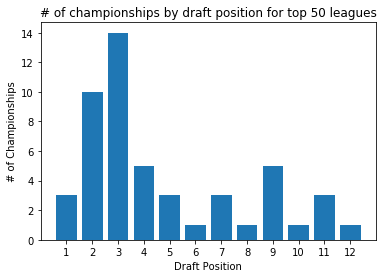

In [58]:
### Number of championships by draft position

x = np.arange(1, 13, step=1)
y = [data[str(i)]['championships'] for i in range(1,13)]

plt.bar(x,y, align='center')
plt.xticks(np.arange(1, 13, step=1.0))
plt.xlabel('Draft Position')
plt.ylabel('# of Championships')
plt.title('# of championships by draft position for top 50 leagues')
plt.show()

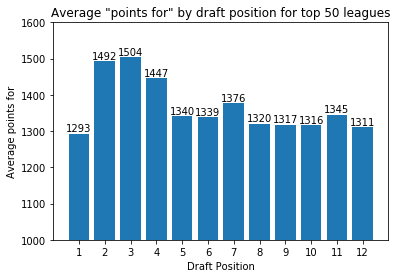

In [95]:
### Average "points for" by draft position

x = np.arange(1, 13, step=1)
y = [data[str(i)]['average_points_for'] for i in range(1,13)]

bar = plt.bar(x,y, align='center')
plt.xticks(np.arange(1, 13, step=1.0))
plt.xlabel('Draft Position')
plt.ylim((1000,1600))
plt.ylabel('Average points for')
plt.title('Average "points for" by draft position for top 50 leagues')

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.show()

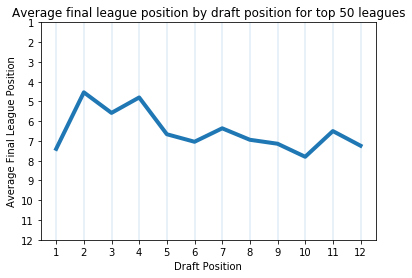

In [96]:
### Average final position in league by draft position

x = np.arange(1, 13, step=1)
y = [data[str(i)]['average_position'] for i in range(1,13)]

plt.plot(x, y, linewidth=4)
plt.ylim((1,12))
plt.xticks(np.arange(1, 13, step=1.0))
plt.yticks(np.arange(1, 13, step=1.0))
plt.gca().invert_yaxis()
for xc in x:
    plt.axvline(x=xc, linewidth=.2)

plt.xlabel('Draft Position')
plt.ylabel('Average Final League Position')
plt.title('Average final league position by draft position for top 50 leagues')
plt.show()